# NLP From Scratch: Translation with a Sequence to Sequence Network and Attention

This is the third and final tutorial on doing “NLP From Scratch”, where we write our own classes and functions to preprocess the data to do our NLP modeling tasks. We hope after you complete this tutorial that you’ll proceed to learn how torchtext can handle much of this preprocessing for you in the three tutorials immediately following this one.

In this project we will be teaching a neural network to translate from French to English.

```
[KEY: > input, = target, < output]

> il est en train de peindre un tableau .
= he is painting a picture .
< he is painting a picture .

> pourquoi ne pas essayer ce vin delicieux ?
= why not try that delicious wine ?
< why not try that delicious wine ?

> elle n est pas poete mais romanciere .
= she is not a poet but a novelist .
< she not not a poet but a novelist .

> vous etes trop maigre .
= you re too skinny .
< you re all alone .
```

… to varying degrees of success.

This is made possible by the simple but powerful idea of the [sequence to sequence network](https://arxiv.org/abs/1409.3215), in which two recurrent neural networks work together to transform one sequence to another. An encoder network condenses an input sequence into a vector, and a decoder network unfolds that vector into a new sequence.

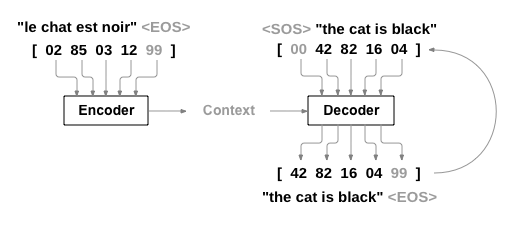

To improve upon this model we’ll use an [attention mechanism](https://arxiv.org/abs/1409.0473), which lets the decoder learn to focus over a specific range of the input sequence.

**Recommended Reading:**

I assume you have at least installed PyTorch, know Python, and understand Tensors:

* [https://pytorch.org/](https://pytorch.org/) For installation instructions
* [Deep Learning with PyTorch: A 60 Minute Blitz](https://pytorch.org/tutorials/beginner/deep_learning_60min_blitz.html) to get started with PyTorch in general
* [Learning PyTorch with Examples](https://pytorch.org/tutorials/beginner/pytorch_with_examples.html) for a wide and deep overview
* [PyTorch for Former Torch Users](https://pytorch.org/tutorials/beginner/former_torchies_tutorial.html) if you are former Lua Torch user

It would also be useful to know about Sequence to Sequence networks and how they work:

* [Learning Phrase Representations using RNN Encoder-Decoder for Statistical Machine Translation](https://arxiv.org/abs/1406.1078)
* [Sequence to Sequence Learning with Neural Networks](https://arxiv.org/abs/1409.3215)
* [Neural Machine Translation by Jointly Learning to Align and Translate](https://arxiv.org/abs/1409.0473)
* [A Neural Conversational Model](https://arxiv.org/abs/1506.05869)

You will also find the previous tutorials on [NLP From Scratch: Classifying Names with a Character-Level RNN](https://pytorch.org/tutorials/intermediate/char_rnn_classification_tutorial.html) and [NLP From Scratch: Generating Names with a Character-Level RNN](https://pytorch.org/tutorials/intermediate/char_rnn_generation_tutorial.html) helpful as those concepts are very similar to the Encoder and Decoder models, respectively.

And for more, read the papers that introduced these topics:

* [Learning Phrase Representations using RNN Encoder-Decoder for Statistical Machine Translation](https://arxiv.org/abs/1406.1078)
* [Sequence to Sequence Learning with Neural Networks](https://arxiv.org/abs/1409.3215)
* [Neural Machine Translation by Jointly Learning to Align and Translate](https://arxiv.org/abs/1409.0473)
* [A Neural Conversational Model](https://arxiv.org/abs/1506.05869)

**Requirements**

In [1]:
from __future__ import unicode_literals, print_function, division
from io import open
import unicodedata
import string
import re
import random

import torch
import torch.nn as nn
from torch import optim
import torch.nn.functional as F

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

## Loading data files

The data for this project is a set of many thousands of English to French translation pairs.

[This question on Open Data Stack Exchange](https://opendata.stackexchange.com/questions/3888/dataset-of-sentences-translated-into-many-languages) pointed me to the open translation site https://tatoeba.org/ which has downloads available at https://tatoeba.org/eng/downloads - and better yet, someone did the extra work of splitting language pairs into individual text files here: https://www.manythings.org/anki/

The English to French pairs are too big to include in the repo, so download to ``data/eng-fra.txt`` before continuing. The file is a tab separated list of translation pairs:

``
I am cold.    J'ai froid.
``

**Note**

Download the data from [here](https://download.pytorch.org/tutorial/data.zip) and extract it to the current directory.

Similar to the character encoding used in the character-level RNN tutorials, we will be representing each word in a language as a one-hot vector, or giant vector of zeros except for a single one (at the index of the word). Compared to the dozens of characters that might exist in a language, there are many many more words, so the encoding vector is much larger. We will however cheat a bit and trim the data to only use a few thousand words per language.

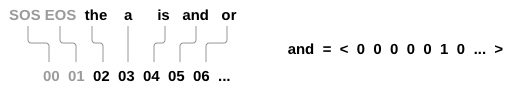

We’ll need a unique index per word to use as the inputs and targets of the networks later. To keep track of all this we will use a helper class called ``Lang`` which has word → index (``word2index``) and index → word (``index2word``) dictionaries, as well as a count of each word ``word2count`` to use to later replace rare words.

In [2]:
%%bash
rm -r data
rm data.zip
wget -c https://download.pytorch.org/tutorial/data.zip
unzip data.zip

Archive:  data.zip
   creating: data/
  inflating: data/eng-fra.txt        
   creating: data/names/
  inflating: data/names/Arabic.txt   
  inflating: data/names/Chinese.txt  
  inflating: data/names/Czech.txt    
  inflating: data/names/Dutch.txt    
  inflating: data/names/English.txt  
  inflating: data/names/French.txt   
  inflating: data/names/German.txt   
  inflating: data/names/Greek.txt    
  inflating: data/names/Irish.txt    
  inflating: data/names/Italian.txt  
  inflating: data/names/Japanese.txt  
  inflating: data/names/Korean.txt   
  inflating: data/names/Polish.txt   
  inflating: data/names/Portuguese.txt  
  inflating: data/names/Russian.txt  
  inflating: data/names/Scottish.txt  
  inflating: data/names/Spanish.txt  
  inflating: data/names/Vietnamese.txt  


--2020-07-02 15:32:54--  https://download.pytorch.org/tutorial/data.zip
Resolving download.pytorch.org (download.pytorch.org)... 99.86.212.76, 99.86.212.109, 99.86.212.125, ...
Connecting to download.pytorch.org (download.pytorch.org)|99.86.212.76|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2882130 (2.7M) [application/zip]
Saving to: 'data.zip’

     0K .......... .......... .......... .......... ..........  1% 35.3M 0s
    50K .......... .......... .......... .......... ..........  3% 3.24M 0s
   100K .......... .......... .......... .......... ..........  5% 38.3M 0s
   150K .......... .......... .......... .......... ..........  7% 22.6M 0s
   200K .......... .......... .......... .......... ..........  8% 76.0M 0s
   250K .......... .......... .......... .......... .......... 10% 22.7M 0s
   300K .......... .......... .......... .......... .......... 12% 19.6M 0s
   350K .......... .......... .......... .......... .......... 14% 20.9M 0s
   400K ......

In [3]:
SOS_token = 0
EOS_token = 1


class Lang:
    def __init__(self, name):
        self.name = name
        self.word2index = {}
        self.word2count = {}
        self.index2word = {0: "SOS", 1: "EOS"}
        self.n_words = 2  # Count SOS and EOS

    def addSentence(self, sentence):
        for word in sentence.split(' '):
            self.addWord(word)

    def addWord(self, word):
        if word not in self.word2index:
            self.word2index[word] = self.n_words
            self.word2count[word] = 1
            self.index2word[self.n_words] = word
            self.n_words += 1
        else:
            self.word2count[word] += 1

The files are all in Unicode, to simplify we will turn Unicode characters to ASCII, make everything lowercase, and trim most punctuation.

In [4]:
# Turn a Unicode string to plain ASCII, thanks to
# https://stackoverflow.com/a/518232/2809427
def unicodeToAscii(s):
    return ''.join(
        c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn'
    )

# Lowercase, trim, and remove non-letter characters


def normalizeString(s):
    s = unicodeToAscii(s.lower().strip())
    s = re.sub(r"([.!?])", r" \1", s)
    s = re.sub(r"[^a-zA-Z.!?]+", r" ", s)
    return s

To read the data file we will split the file into lines, and then split lines into pairs. The files are all English → Other Language, so if we want to translate from Other Language → English I added the ``reverse`` flag to reverse the pairs.

In [5]:
def readLangs(lang1, lang2, reverse=False):
    print("Reading lines...")

    # Read the file and split into lines
    lines = open('data/%s-%s.txt' % (lang1, lang2), encoding='utf-8').\
        read().strip().split('\n')

    # Split every line into pairs and normalize
    pairs = [[normalizeString(s) for s in l.split('\t')] for l in lines]

    # Reverse pairs, make Lang instances
    if reverse:
        pairs = [list(reversed(p)) for p in pairs]
        input_lang = Lang(lang2)
        output_lang = Lang(lang1)
    else:
        input_lang = Lang(lang1)
        output_lang = Lang(lang2)

    return input_lang, output_lang, pairs

Since there are a lot of example sentences and we want to train something quickly, we’ll trim the data set to only relatively short and simple sentences. Here the maximum length is 10 words (that includes ending punctuation) and we’re filtering to sentences that translate to the form “I am” or “He is” etc. (accounting for apostrophes replaced earlier).

In [6]:
MAX_LENGTH = 10

eng_prefixes = (
    "i am ", "i m ",
    "he is", "he s ",
    "she is", "she s ",
    "you are", "you re ",
    "we are", "we re ",
    "they are", "they re "
)


def filterPair(p):
    return len(p[0].split(' ')) < MAX_LENGTH and \
        len(p[1].split(' ')) < MAX_LENGTH and \
        p[1].startswith(eng_prefixes)


def filterPairs(pairs):
    return [pair for pair in pairs if filterPair(pair)]

The full process for preparing the data is:

* Read text file and split into lines, split lines into pairs
* Normalize text, filter by length and content
* Make word lists from sentences in pairs

In [7]:
def prepareData(lang1, lang2, reverse=False):
    input_lang, output_lang, pairs = readLangs(lang1, lang2, reverse)
    print("Read %s sentence pairs" % len(pairs))
    pairs = filterPairs(pairs)
    print("Trimmed to %s sentence pairs" % len(pairs))
    print("Counting words...")
    for pair in pairs:
        input_lang.addSentence(pair[0])
        output_lang.addSentence(pair[1])
    print("Counted words:")
    print(input_lang.name, input_lang.n_words)
    print(output_lang.name, output_lang.n_words)
    return input_lang, output_lang, pairs


input_lang, output_lang, pairs = prepareData('eng', 'fra', True)
print(random.choice(pairs))

Reading lines...
Read 135842 sentence pairs
Trimmed to 10599 sentence pairs
Counting words...
Counted words:
fra 4345
eng 2803
['il est connu comme un grand peintre .', 'he is known as a great painter .']


## The Seq2Seq Model

A Recurrent Neural Network, or RNN, is a network that operates on a sequence and uses its own output as input for subsequent steps.

A [Sequence to Sequence network](https://arxiv.org/abs/1409.3215), or seq2seq network, or [Encoder Decoder network](https://arxiv.org/pdf/1406.1078v3.pdf), is a model consisting of two RNNs called the encoder and decoder. The encoder reads an input sequence and outputs a single vector, and the decoder reads that vector to produce an output sequence.

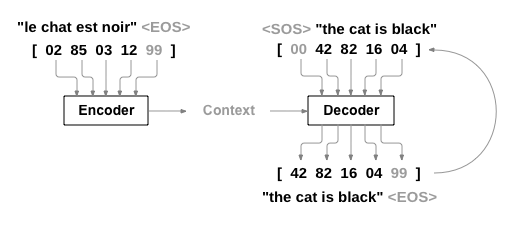

Unlike sequence prediction with a single RNN, where every input corresponds to an output, the seq2seq model frees us from sequence length and order, which makes it ideal for translation between two languages.

Consider the sentence “Je ne suis pas le chat noir” → “I am not the black cat”. Most of the words in the input sentence have a direct translation in the output sentence, but are in slightly different orders, e.g. “chat noir” and “black cat”. Because of the “ne/pas” construction there is also one more word in the input sentence. It would be difficult to produce a correct translation directly from the sequence of input words.

With a seq2seq model the encoder creates a single vector which, in the ideal case, encodes the “meaning” of the input sequence into a single vector — a single point in some N dimensional space of sentences.

### The Encoder

The encoder of a seq2seq network is a RNN that outputs some value for every word from the input sentence. For every input word the encoder outputs a vector and a hidden state, and uses the hidden state for the next input word.

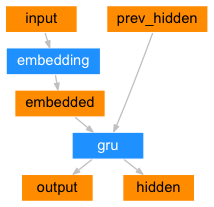

In [8]:
class EncoderRNN(nn.Module):
    def __init__(self, input_size, hidden_size):
        super(EncoderRNN, self).__init__()
        self.hidden_size = hidden_size

        self.embedding = nn.Embedding(input_size, hidden_size)
        self.gru = nn.GRU(hidden_size, hidden_size)

    def forward(self, input, hidden):
        embedded = self.embedding(input).view(1, 1, -1)
        output = embedded
        output, hidden = self.gru(output, hidden)
        return output, hidden

    def initHidden(self):
        return torch.zeros(1, 1, self.hidden_size, device=device)

### The Decoder

The decoder is another RNN that takes the encoder output vector(s) and outputs a sequence of words to create the translation.

#### Simple Decoder

In the simplest seq2seq decoder we use only last output of the encoder. This last output is sometimes called the context vector as it encodes context from the entire sequence. This context vector is used as the initial hidden state of the decoder.

At every step of decoding, the decoder is given an input token and hidden state. The initial input token is the start-of-string <SOS> token, and the first hidden state is the context vector (the encoder’s last hidden state).
    
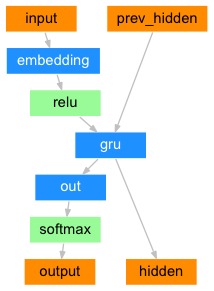

In [9]:
class DecoderRNN(nn.Module):
    def __init__(self, hidden_size, output_size):
        super(DecoderRNN, self).__init__()
        self.hidden_size = hidden_size

        self.embedding = nn.Embedding(output_size, hidden_size)
        self.gru = nn.GRU(hidden_size, hidden_size)
        self.out = nn.Linear(hidden_size, output_size)
        self.softmax = nn.LogSoftmax(dim=1)

    def forward(self, input, hidden):
        output = self.embedding(input).view(1, 1, -1)
        output = F.relu(output)
        output, hidden = self.gru(output, hidden)
        output = self.softmax(self.out(output[0]))
        return output, hidden

    def initHidden(self):
        return torch.zeros(1, 1, self.hidden_size, device=device)

I encourage you to train and observe the results of this model, but to save space we’ll be going straight for the gold and introducing the Attention Mechanism.

#### Attention Decoder

If only the context vector is passed betweeen the encoder and decoder, that single vector carries the burden of encoding the entire sentence.

Attention allows the decoder network to “focus” on a different part of the encoder’s outputs for every step of the decoder’s own outputs. First we calculate a set of *attention weights*. These will be multiplied by the encoder output vectors to create a weighted combination. The result (called ``attn_applied`` in the code) should contain information about that specific part of the input sequence, and thus help the decoder choose the right output words.

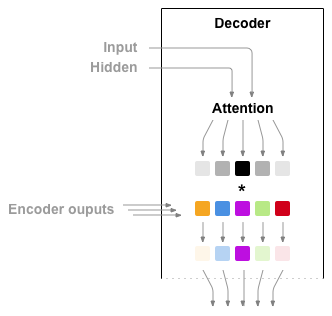

Calculating the attention weights is done with another feed-forward layer ``attn``, using the decoder’s input and hidden state as inputs. Because there are sentences of all sizes in the training data, to actually create and train this layer we have to choose a maximum sentence length (input length, for encoder outputs) that it can apply to. Sentences of the maximum length will use all the attention weights, while shorter sentences will only use the first few.

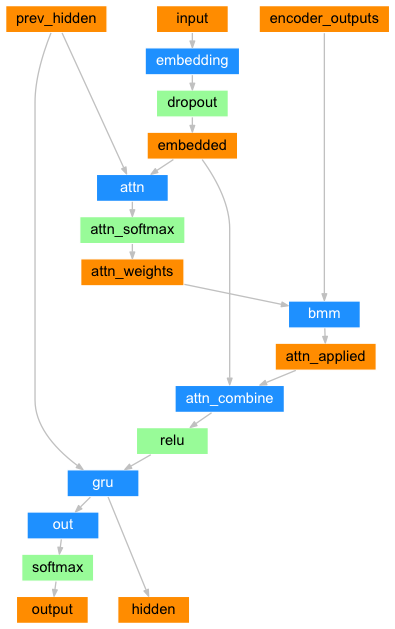

In [53]:
class AttnDecoderRNN(nn.Module):
    def __init__(self, hidden_size, output_size, dropout_p=0.1, max_length=MAX_LENGTH):
        super(AttnDecoderRNN, self).__init__()
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.dropout_p = dropout_p
        self.max_length = max_length

        self.embedding = nn.Embedding(self.output_size, self.hidden_size)
        self.attn = nn.Linear(self.hidden_size * 2, self.max_length)
        self.attn_combine = nn.Linear(self.hidden_size * 2, self.hidden_size)
        self.dropout = nn.Dropout(self.dropout_p)
        self.gru = nn.GRU(self.hidden_size, self.hidden_size)
        self.out = nn.Linear(self.hidden_size, self.output_size)

    def forward(self, input, hidden, encoder_outputs):
        embedded = self.embedding(input).view(1, 1, -1)
        embedded = self.dropout(embedded)
        
        print("embedded size")
        print(embedded.size())
        print(embedded)
        
        attn_weights = F.softmax(
            self.attn(torch.cat((embedded[0], hidden[0]), 1)), dim=1)
        
        print("attn_weights size")
        print(attn_weights.size())
        print(attn_weights)
        
        print("encoder_outputs size")
        print(encoder_outputs.size())
        print(encoder_outputs)
        
        attn_applied = torch.bmm(attn_weights.unsqueeze(0),
                                 encoder_outputs.unsqueeze(0))

        print("attn_aplied size")
        print(attn_applied.size())
        print(attn_applied)
        
        output = torch.cat((embedded[0], attn_applied[0]), 1)
        output = self.attn_combine(output).unsqueeze(0)

        output = F.relu(output)
        output, hidden = self.gru(output, hidden)

        output = F.log_softmax(self.out(output[0]), dim=1)
        return output, hidden, attn_weights

    def initHidden(self):
        return torch.zeros(1, 1, self.hidden_size, device=device)

**Note**

There are other forms of attention that work around the length limitation by using a relative position approach. Read about “local attention” in [Effective Approaches to Attention-based Neural Machine Translation](https://arxiv.org/abs/1508.04025).

## Training
### Preparing Training Data

To train, for each pair we will need an input tensor (indexes of the words in the input sentence) and target tensor (indexes of the words in the target sentence). While creating these vectors we will append the EOS token to both sequences.

In [54]:
def indexesFromSentence(lang, sentence):
    return [lang.word2index[word] for word in sentence.split(' ')]


def tensorFromSentence(lang, sentence):
    indexes = indexesFromSentence(lang, sentence)
    indexes.append(EOS_token)
    return torch.tensor(indexes, dtype=torch.long, device=device).view(-1, 1)


def tensorsFromPair(pair):
    input_tensor = tensorFromSentence(input_lang, pair[0])
    target_tensor = tensorFromSentence(output_lang, pair[1])
    return (input_tensor, target_tensor)


In [55]:
input_tensor, target_tensor = tensorsFromPair(random.choice(pairs))
print(input_tensor)
print(target_tensor)

tensor([[210],
        [211],
        [180],
        [  5],
        [  1]], device='cuda:0')
tensor([[129],
        [ 78],
        [115],
        [  4],
        [  1]], device='cuda:0')


### Training the Model

To train we run the input sentence through the encoder, and keep track of every output and the latest hidden state. Then the decoder is given the ``<SOS>`` token as its first input, and the last hidden state of the encoder as its first hidden state.

“Teacher forcing” is the concept of using the real target outputs as each next input, instead of using the decoder’s guess as the next input. Using teacher forcing causes it to converge faster but [when the trained network is exploited, it may exhibit instability](http://citeseerx.ist.psu.edu/viewdoc/download?doi=10.1.1.378.4095&rep=rep1&type=pdf).

You can observe outputs of teacher-forced networks that read with coherent grammar but wander far from the correct translation - intuitively it has learned to represent the output grammar and can “pick up” the meaning once the teacher tells it the first few words, but it has not properly learned how to create the sentence from the translation in the first place.

Because of the freedom PyTorch’s autograd gives us, we can randomly choose to use teacher forcing or not with a simple if statement. Turn ``teacher_forcing_ratio`` up to use more of it.

In [56]:
teacher_forcing_ratio = 0.5


def train(input_tensor, target_tensor, encoder, decoder, encoder_optimizer, decoder_optimizer, criterion, max_length=MAX_LENGTH):
    encoder_hidden = encoder.initHidden()

    encoder_optimizer.zero_grad()
    decoder_optimizer.zero_grad()

    input_length = input_tensor.size(0)
    target_length = target_tensor.size(0)

    encoder_outputs = torch.zeros(max_length, encoder.hidden_size, device=device)

    loss = 0

    for ei in range(input_length):
        encoder_output, encoder_hidden = encoder(
            input_tensor[ei], encoder_hidden)
        encoder_outputs[ei] = encoder_output[0, 0]

    decoder_input = torch.tensor([[SOS_token]], device=device)

    decoder_hidden = encoder_hidden

    use_teacher_forcing = True if random.random() < teacher_forcing_ratio else False

    if use_teacher_forcing:
        # Teacher forcing: Feed the target as the next input
        for di in range(target_length):
            decoder_output, decoder_hidden, decoder_attention = decoder(
                decoder_input, decoder_hidden, encoder_outputs)
            loss += criterion(decoder_output, target_tensor[di])
            decoder_input = target_tensor[di]  # Teacher forcing

    else:
        # Without teacher forcing: use its own predictions as the next input
        for di in range(target_length):
            decoder_output, decoder_hidden, decoder_attention = decoder(
                decoder_input, decoder_hidden, encoder_outputs)
            topv, topi = decoder_output.topk(1)
            decoder_input = topi.squeeze().detach()  # detach from history as input

            loss += criterion(decoder_output, target_tensor[di])
            if decoder_input.item() == EOS_token:
                break

    loss.backward()

    encoder_optimizer.step()
    decoder_optimizer.step()

    return loss.item() / target_length

This is a helper function to print time elapsed and estimated time remaining given the current time and progress %.

In [57]:
import time
import math


def asMinutes(s):
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)


def timeSince(since, percent):
    now = time.time()
    s = now - since
    es = s / (percent)
    rs = es - s
    return '%s (- %s)' % (asMinutes(s), asMinutes(rs))

The whole training process looks like this:

* Start a timer
* Initialize optimizers and criterion
* Create set of training pairs
* Start empty losses array for plotting

Then we call ``train`` many times and occasionally print the progress (% of examples, time so far, estimated time) and average loss.

In [58]:
def trainIters(encoder, decoder, n_iters, print_every=1000, plot_every=100, learning_rate=0.01):
    start = time.time()
    plot_losses = []
    print_loss_total = 0  # Reset every print_every
    plot_loss_total = 0  # Reset every plot_every

    encoder_optimizer = optim.SGD(encoder.parameters(), lr=learning_rate)
    decoder_optimizer = optim.SGD(decoder.parameters(), lr=learning_rate)
    training_pairs = [tensorsFromPair(random.choice(pairs))
                      for i in range(n_iters)]
    criterion = nn.NLLLoss()

    for iter in range(1, n_iters + 1):
        training_pair = training_pairs[iter - 1]
        input_tensor = training_pair[0]
        target_tensor = training_pair[1]

        loss = train(input_tensor, target_tensor, encoder,
                     decoder, encoder_optimizer, decoder_optimizer, criterion)
        print_loss_total += loss
        plot_loss_total += loss

        if iter % print_every == 0:
            print_loss_avg = print_loss_total / print_every
            print_loss_total = 0
            print('%s (%d %d%%) %.4f' % (timeSince(start, iter / n_iters),
                                         iter, iter / n_iters * 100, print_loss_avg))

        if iter % plot_every == 0:
            plot_loss_avg = plot_loss_total / plot_every
            plot_losses.append(plot_loss_avg)
            plot_loss_total = 0

    showPlot(plot_losses)

## Plotting results

Plotting is done with matplotlib, using the array of loss values ``plot_losses`` saved while training.

In [59]:
import matplotlib.pyplot as plt
plt.switch_backend('agg')
import matplotlib.ticker as ticker
import numpy as np

%matplotlib inline
def showPlot(points):
    plt.figure()
    fig, ax = plt.subplots()
    # this locator puts ticks at regular intervals
    loc = ticker.MultipleLocator(base=0.2)
    ax.yaxis.set_major_locator(loc)
    plt.plot(points)

## Evaluation

Evaluation is mostly the same as training, but there are no targets so we simply feed the decoder’s predictions back to itself for each step. Every time it predicts a word we add it to the output string, and if it predicts the EOS token we stop there. We also store the decoder’s attention outputs for display later.

In [60]:
def evaluate(encoder, decoder, sentence, max_length=MAX_LENGTH):
    with torch.no_grad():
        input_tensor = tensorFromSentence(input_lang, sentence)
        input_length = input_tensor.size()[0]
        encoder_hidden = encoder.initHidden()

        encoder_outputs = torch.zeros(max_length, encoder.hidden_size, device=device)

        for ei in range(input_length):
            encoder_output, encoder_hidden = encoder(input_tensor[ei],
                                                     encoder_hidden)
            encoder_outputs[ei] += encoder_output[0, 0]

        decoder_input = torch.tensor([[SOS_token]], device=device)  # SOS

        decoder_hidden = encoder_hidden

        decoded_words = []
        decoder_attentions = torch.zeros(max_length, max_length)

        for di in range(max_length):
            decoder_output, decoder_hidden, decoder_attention = decoder(
                decoder_input, decoder_hidden, encoder_outputs)
            decoder_attentions[di] = decoder_attention.data
            topv, topi = decoder_output.data.topk(1)
            if topi.item() == EOS_token:
                decoded_words.append('<EOS>')
                break
            else:
                decoded_words.append(output_lang.index2word[topi.item()])

            decoder_input = topi.squeeze().detach()

        return decoded_words, decoder_attentions[:di + 1]

We can evaluate random sentences from the training set and print out the input, target, and output to make some subjective quality judgements:

In [61]:
def evaluateRandomly(encoder, decoder, n=10):
    for i in range(n):
        pair = random.choice(pairs)
        print('>', pair[0])
        print('=', pair[1])
        output_words, attentions = evaluate(encoder, decoder, pair[0])
        output_sentence = ' '.join(output_words)
        print('<', output_sentence)
        print('')

## Training and Evaluating

With all these helper functions in place (it looks like extra work, but it makes it easier to run multiple experiments) we can actually initialize a network and start training.

Remember that the input sentences were heavily filtered. For this small dataset we can use relatively small networks of 256 hidden nodes and a single GRU layer. After about 40 minutes on a MacBook CPU we’ll get some reasonable results.

**NOTE**

If you run this notebook you can train, interrupt the kernel, evaluate, and continue training later. Comment out the lines where the encoder and decoder are initialized and run ``trainIters`` again.

In [62]:
hidden_size = 256
encoder1 = EncoderRNN(input_lang.n_words, hidden_size).to(device)
attn_decoder1 = AttnDecoderRNN(hidden_size, output_lang.n_words, dropout_p=0.1).to(device)

trainIters(encoder1, attn_decoder1, 75000, print_every=5000)

embedded size
torch.Size([1, 1, 256])
tensor([[[ 8.7472e-02,  4.0022e-01, -9.6455e-01, -6.8092e-01,  3.7529e-01,
          -2.0166e-01,  1.4643e+00,  0.0000e+00, -3.5829e+00,  9.0700e-01,
           4.2786e-01, -6.2946e-01,  2.6014e+00, -6.3073e-01, -5.4134e-01,
          -1.5811e-01,  8.5166e-01,  0.0000e+00,  4.5522e-01,  4.3629e-01,
          -6.3291e-01,  0.0000e+00,  1.6394e+00,  1.5113e+00,  7.5305e-01,
           0.0000e+00, -1.8859e-01, -7.6042e-01,  1.6533e+00,  8.6126e-01,
           1.2313e+00,  1.2194e+00, -1.0340e+00, -8.3093e-02, -1.5341e+00,
           1.3956e+00,  2.8036e-01,  0.0000e+00,  1.9775e-01,  1.5996e+00,
          -4.5892e-01, -1.3979e+00, -2.6939e-01, -1.7137e+00, -1.5230e+00,
           6.6836e-01,  0.0000e+00,  3.7149e-01, -1.3401e+00,  0.0000e+00,
          -6.2931e-01,  2.7501e+00,  6.0995e-01, -1.0282e+00, -2.4795e-02,
           2.0437e-01, -8.8097e-01, -1.2503e+00, -2.3763e-01, -4.2657e-01,
           1.0982e+00,  1.4065e+00, -2.0186e-01, -5.0092e-01, 

tensor([[[ 3.4145e-02, -3.1724e-02, -7.1664e-02,  9.4868e-02,  1.2502e-02,
           1.3597e-01, -1.1243e-01,  4.7269e-02,  1.2357e-02,  7.2454e-02,
           2.5720e-01, -6.0219e-02, -7.7615e-02,  1.5432e-01,  2.4164e-01,
          -5.2376e-02,  4.5649e-02,  2.8968e-02, -1.1284e-02, -6.2273e-02,
          -1.6959e-02, -4.0610e-02,  1.0507e-01, -2.5454e-01, -1.8688e-01,
          -9.3478e-02, -6.9902e-02, -1.4469e-01,  1.1220e-01, -3.4051e-02,
           1.3000e-02,  1.6504e-01, -7.2600e-02, -3.1587e-01,  5.8873e-02,
           1.4926e-01,  1.1003e-01, -1.1381e-01,  6.1990e-02,  2.2600e-01,
           1.9019e-01,  6.5146e-02, -6.4913e-02, -1.4317e-04, -1.6204e-01,
           1.9859e-01, -2.9055e-02,  4.2144e-02,  9.8399e-03, -1.6791e-03,
          -6.1758e-02, -3.6429e-02, -1.2048e-01, -4.3454e-03, -1.6694e-02,
          -1.8705e-01, -9.3560e-02, -1.1286e-01,  2.6818e-02,  1.7091e-01,
           2.7706e-01, -6.1950e-02, -5.5344e-02, -2.8506e-02,  5.1349e-02,
           2.0739e-01, -2

tensor([[[ 8.7153e-02,  0.0000e+00, -9.6453e-01, -6.8083e-01,  3.7527e-01,
          -2.0185e-01,  1.4644e+00, -8.3720e-02, -3.5829e+00,  9.0696e-01,
           4.2782e-01, -6.2933e-01,  0.0000e+00, -6.3062e-01, -5.4141e-01,
          -1.5815e-01,  8.5154e-01,  1.0940e+00,  4.5521e-01,  4.3616e-01,
          -6.3306e-01, -3.8214e-01,  0.0000e+00,  1.5112e+00,  7.5310e-01,
          -7.6007e-02, -1.8858e-01, -7.6029e-01,  1.6532e+00,  8.6128e-01,
           1.2313e+00,  1.2194e+00,  0.0000e+00, -8.3131e-02, -1.5340e+00,
           1.3955e+00,  2.8048e-01, -3.7439e+00,  1.9765e-01,  1.5998e+00,
          -4.5899e-01, -1.3979e+00, -2.6927e-01, -1.7138e+00, -1.5231e+00,
           6.6813e-01,  5.4032e-01,  3.7145e-01, -1.3402e+00,  1.4477e-01,
          -6.2929e-01,  2.7501e+00,  6.1010e-01, -1.0283e+00,  0.0000e+00,
           2.0441e-01, -8.8097e-01, -1.2505e+00, -2.3752e-01, -4.2651e-01,
           1.0984e+00,  1.4067e+00, -2.0199e-01, -5.0086e-01, -2.9617e+00,
           5.5180e-01,  0

embedded size
torch.Size([1, 1, 256])
tensor([[[ 8.7240e-02,  0.0000e+00,  0.0000e+00, -6.8087e-01,  3.7521e-01,
          -2.0185e-01,  1.4645e+00, -8.3692e-02, -3.5829e+00,  9.0690e-01,
           4.2784e-01, -6.2928e-01,  2.6015e+00, -6.3056e-01, -5.4136e-01,
          -1.5808e-01,  8.5146e-01,  0.0000e+00,  4.5521e-01,  4.3619e-01,
           0.0000e+00, -3.8210e-01,  1.6394e+00,  1.5111e+00,  7.5305e-01,
          -7.6042e-02, -1.8846e-01, -7.6024e-01,  1.6532e+00,  8.6127e-01,
           1.2313e+00,  1.2194e+00,  0.0000e+00, -8.3095e-02, -1.5340e+00,
           0.0000e+00,  2.8056e-01, -3.7438e+00,  1.9761e-01,  1.5998e+00,
          -4.5897e-01, -1.3978e+00, -2.6925e-01, -1.7139e+00, -1.5231e+00,
           6.6809e-01,  5.4037e-01,  3.7146e-01, -1.3402e+00,  1.4475e-01,
          -6.2935e-01,  2.7501e+00,  6.1004e-01, -1.0284e+00, -2.4802e-02,
           2.0439e-01, -8.8103e-01, -1.2505e+00, -2.3753e-01, -4.2646e-01,
           0.0000e+00,  0.0000e+00, -2.0209e-01, -5.0076e-01, 

tensor([[[ 9.9223e-02, -4.6215e-02, -1.7133e-01, -4.7968e-02,  8.4235e-02,
           1.7286e-01, -1.6948e-01, -9.6338e-02, -1.6665e-02, -1.3457e-01,
           1.3619e-01, -1.8078e-01, -2.0735e-01, -2.2242e-01,  5.8855e-02,
           1.7690e-01, -1.6557e-02, -8.5332e-02, -1.1937e-01, -1.1152e-01,
          -1.5227e-01,  7.7893e-03, -9.3195e-02,  3.1246e-02,  3.4903e-02,
           1.3184e-01, -1.2055e-02, -7.8477e-02, -4.0574e-02, -4.8501e-02,
          -1.3814e-02,  9.6750e-02,  1.2434e-01, -1.5563e-01,  8.2119e-02,
          -1.0392e-01, -1.2098e-01, -4.3809e-03, -1.3308e-01, -1.3029e-01,
          -1.1423e-02,  2.0634e-01, -1.3993e-02, -7.3429e-02,  9.1216e-02,
          -5.3715e-03,  3.2193e-02, -1.4533e-01,  2.9563e-02,  3.0254e-02,
          -1.6916e-01, -6.2153e-02, -4.4088e-03, -1.4928e-01, -3.3486e-01,
          -2.3552e-02, -2.6242e-02, -1.5171e-01,  7.3562e-02,  1.6383e-01,
          -1.1793e-01,  6.6423e-02,  3.8818e-02, -1.2996e-02,  1.4407e-01,
           2.5403e-02,  1

tensor([[[ 8.7280e-01,  0.0000e+00,  3.1480e-01, -1.0845e+00, -1.1723e+00,
           0.0000e+00,  0.0000e+00,  1.3513e+00,  1.9047e-01,  6.1739e-01,
           1.9026e+00,  6.0244e-01,  0.0000e+00, -9.1596e-01,  0.0000e+00,
          -6.8524e-02, -1.6329e+00, -9.4349e-01,  1.3609e+00, -1.4346e+00,
          -1.4074e-01, -5.2333e-01, -1.1193e+00, -2.5947e+00, -7.5588e-02,
           1.3913e+00, -6.1923e-01,  0.0000e+00,  1.2765e-01,  5.5384e-01,
           9.1469e-01, -3.5206e-03,  2.2301e-01,  2.0152e+00, -6.3876e-02,
          -1.4085e+00, -1.1195e-01, -8.1780e-01,  3.1465e-01,  8.5297e-02,
           8.6198e-01, -8.9993e-01,  1.0091e+00, -1.5631e+00,  0.0000e+00,
          -3.0002e-01,  7.0455e-01, -6.0117e-01, -1.0205e+00,  1.1162e+00,
          -1.3220e+00,  0.0000e+00,  6.6661e-01, -8.4650e-01,  2.2739e-01,
          -3.0880e-01, -1.4342e+00,  0.0000e+00,  0.0000e+00,  2.1808e+00,
          -1.0062e+00,  3.6134e-02, -2.8016e-01,  2.6585e-01, -6.2743e-02,
           3.9425e-01,  5

embedded size
torch.Size([1, 1, 256])
tensor([[[ 8.7032e-02,  3.9998e-01, -9.6476e-01, -6.8089e-01,  3.7535e-01,
          -2.0191e-01,  1.4645e+00, -8.3636e-02, -3.5830e+00,  0.0000e+00,
           4.2790e-01, -6.2913e-01,  2.6020e+00, -6.3026e-01, -5.4128e-01,
          -1.5797e-01,  8.5129e-01,  1.0942e+00,  4.5521e-01,  4.3617e-01,
           0.0000e+00, -3.8238e-01,  1.6396e+00,  1.5109e+00,  7.5316e-01,
          -7.5905e-02, -1.8816e-01, -7.6000e-01,  0.0000e+00,  0.0000e+00,
           1.2314e+00,  1.2191e+00, -1.0341e+00,  0.0000e+00, -1.5340e+00,
           0.0000e+00,  2.8071e-01, -3.7437e+00,  1.9764e-01,  1.5999e+00,
          -4.5904e-01, -1.3977e+00, -2.6891e-01, -1.7142e+00, -1.5232e+00,
           6.6775e-01,  5.4040e-01,  3.7118e-01, -1.3402e+00,  1.4451e-01,
          -6.2936e-01,  2.7504e+00,  6.0997e-01, -1.0285e+00, -2.4920e-02,
           2.0409e-01, -8.8119e-01, -1.2510e+00, -2.3737e-01, -4.2611e-01,
           0.0000e+00,  1.4070e+00, -2.0239e-01, -5.0074e-01, 

tensor([[[-0.0447,  1.2545, -0.4664,  1.7172,  2.1264, -0.2519, -0.9080,
          -0.0988,  1.1704, -2.1523, -0.5855, -1.1158, -2.9079,  0.3782,
           2.3037,  0.7980,  0.0000, -0.6149, -0.2803,  0.1081,  0.1244,
           0.2528, -0.6048,  0.6490,  0.0000, -0.0134, -0.9920, -1.4426,
           0.0000,  0.0000,  2.7913,  0.0000, -1.2161, -1.0196,  0.0882,
          -0.0185, -0.6008,  0.2673,  0.6425,  0.0000, -0.2679, -0.9844,
           0.1589, -0.2239,  1.0190, -0.3816,  0.0000, -2.1849, -2.1085,
           0.4285,  0.0000,  0.0000,  0.4625,  0.4323, -2.0464,  0.0000,
           0.0000, -0.1242, -0.8171,  1.5115,  0.3691, -0.7989, -0.3513,
          -0.4275,  0.1153, -1.0634,  1.2920, -1.1348, -1.4301,  0.7686,
           0.7184, -0.2438, -0.7988,  0.0000, -1.2764,  0.6311,  0.2607,
           0.1704, -1.4213, -2.2301,  1.6304,  0.1554,  1.0572, -0.0068,
           1.0074,  1.7522, -0.5065,  0.2261,  1.5821,  0.0145,  0.8280,
           0.0000, -0.3061, -2.0888, -0.1636,  0.79

tensor([[[ 0.0733, -0.0714, -0.1553, -0.0848, -0.0408,  0.2138, -0.2869,
          -0.1863, -0.0505, -0.1049,  0.1700, -0.1111, -0.0813, -0.2052,
           0.0698,  0.1375,  0.0039, -0.0137, -0.0748, -0.1221, -0.1847,
          -0.0245, -0.0938,  0.0413,  0.0324,  0.1842, -0.0017, -0.0544,
          -0.0989, -0.0500,  0.0326,  0.0935,  0.2289, -0.1654,  0.0680,
          -0.1808, -0.0735, -0.1037, -0.1428, -0.1371,  0.0273,  0.1314,
           0.0479, -0.2659, -0.0640,  0.0958,  0.1219, -0.2032,  0.0680,
          -0.0021, -0.2061, -0.1211, -0.1061, -0.1860, -0.3925, -0.0610,
           0.0012, -0.0734,  0.0624,  0.2425, -0.1212, -0.0277, -0.0127,
          -0.0695,  0.0949,  0.0164, -0.0332, -0.1164,  0.0896, -0.0894,
           0.3016,  0.2281,  0.0839,  0.0380,  0.0377,  0.0102,  0.2996,
           0.0683,  0.0013,  0.2027, -0.0974,  0.0379, -0.1309,  0.1032,
          -0.0572,  0.0741, -0.0748,  0.1816,  0.0276, -0.0288,  0.1231,
          -0.1210, -0.1099,  0.0127,  0.0639,  0.18

tensor([[[ 1.8457e-01, -7.4164e-02, -1.7076e-01,  7.5362e-02, -9.9991e-02,
           2.2435e-01, -2.0265e-01, -2.5482e-01,  2.1559e-02,  1.2418e-01,
           6.0407e-02, -1.4364e-01,  9.3264e-02, -7.9380e-02,  1.6890e-01,
           3.0903e-01,  1.0991e-01, -6.4092e-02, -2.0107e-01, -6.6658e-02,
          -2.5539e-01, -7.8334e-02, -1.5023e-02, -8.6598e-02, -2.1955e-02,
           2.3590e-02,  7.0492e-02, -8.8597e-04, -1.4881e-01, -9.7246e-02,
           1.9837e-02,  1.6935e-02,  1.8577e-02,  1.3068e-01,  1.9246e-02,
          -1.1810e-01, -1.3039e-01,  1.1162e-01, -1.4378e-01, -1.2290e-01,
           3.8308e-02,  1.2830e-01,  3.9312e-02, -1.4766e-01,  1.4300e-01,
           6.3388e-02, -8.8155e-02, -1.0306e-01,  2.1586e-01, -3.2368e-02,
          -2.1686e-01, -3.1529e-01,  7.5937e-02, -4.0684e-02, -2.7699e-01,
          -8.2716e-02, -1.7348e-01,  2.7550e-01, -3.5516e-02,  1.8434e-02,
           1.6343e-02,  2.4119e-02,  1.7537e-03,  3.8415e-02,  2.4028e-01,
           2.5464e-02,  9

tensor([[0.0198, 0.2455, 0.1044, 0.0464, 0.1140, 0.1465, 0.0333, 0.1673, 0.0680,
         0.0548]], device='cuda:0', grad_fn=<SoftmaxBackward>)
encoder_outputs size
torch.Size([10, 256])
tensor([[ 0.2545, -0.0010, -0.0875,  ...,  0.1592,  0.0317,  0.0431],
        [ 0.2202, -0.1033, -0.5299,  ...,  0.0377, -0.0375,  0.1093],
        [ 0.1181, -0.0401, -0.6793,  ..., -0.3293, -0.2103,  0.3149],
        ...,
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000]],
       device='cuda:0', grad_fn=<CopySlices>)
attn_aplied size
torch.Size([1, 1, 256])
tensor([[[ 0.1747,  0.0117, -0.3994, -0.1470,  0.0586,  0.0633, -0.0473,
          -0.2097, -0.0074, -0.1308,  0.1113,  0.0597, -0.0928,  0.0340,
           0.2250,  0.1785,  0.2654,  0.0646, -0.1498,  0.0633, -0.0906,
           0.0133,  0.1847, -0.0843, -0.0395, -0.2317,  0.1081, -0.1034,


tensor([[[ 0.2567,  0.1543, -0.3090,  0.0163, -0.0748, -0.1318, -0.0082,
          -0.2526, -0.0035, -0.1605,  0.0313, -0.0873, -0.2893,  0.0013,
           0.1797,  0.0081,  0.2066,  0.1385, -0.2740,  0.0807, -0.1518,
          -0.2251,  0.1705,  0.1560, -0.3171, -0.2166,  0.0536, -0.2244,
          -0.1003,  0.0193,  0.0730, -0.2726, -0.2103, -0.2455, -0.1108,
          -0.0204, -0.2174, -0.1387, -0.2010, -0.0643, -0.1790,  0.0624,
          -0.1932,  0.0532,  0.2379,  0.0779, -0.0309, -0.1618,  0.1607,
          -0.0992, -0.0183, -0.0542, -0.3780, -0.1668, -0.0694,  0.0332,
          -0.0649, -0.0055,  0.1834,  0.1612, -0.0113,  0.0406, -0.3505,
           0.0008, -0.1893, -0.0294,  0.0060,  0.2066, -0.2234,  0.1375,
          -0.0223,  0.1594, -0.0939,  0.2857, -0.0726,  0.0511,  0.1709,
           0.1742,  0.0534,  0.2260, -0.1623, -0.2543, -0.2836,  0.0253,
          -0.1661,  0.1732,  0.0594,  0.0011,  0.1411, -0.1319,  0.1382,
          -0.0068, -0.0043, -0.0713, -0.0995,  0.16

tensor([[[ 1.0425e-01,  6.9765e-02, -1.0884e-01, -3.9234e-02, -1.2305e-01,
          -3.3259e-02, -1.5176e-01, -9.9302e-02, -7.7796e-02,  1.4058e-01,
           1.6396e-01,  6.3507e-03, -3.4175e-02,  1.4959e-02,  1.6165e-01,
           8.1912e-03, -1.2436e-02,  1.3257e-01, -1.3006e-01, -3.7267e-02,
          -1.3308e-01,  8.6628e-03, -9.5937e-02, -4.1392e-02, -1.5250e-01,
           1.7863e-02, -9.4406e-03, -1.6281e-01,  6.2962e-02, -8.3404e-02,
           1.5197e-01, -8.3798e-03, -8.6287e-02, -2.6315e-01, -5.8515e-02,
           4.2297e-02,  9.0268e-02, -1.0379e-02, -5.7069e-02,  9.5909e-03,
          -5.5482e-02,  1.8800e-01, -1.2123e-01, -4.5148e-02,  1.3258e-01,
           8.6097e-02,  2.1803e-01, -2.4189e-01,  3.8453e-02, -4.8596e-02,
           7.7369e-03, -6.9033e-02, -9.6901e-02, -2.6332e-03, -1.5796e-01,
          -4.0055e-03, -2.3564e-02,  9.8441e-02, -2.4174e-02,  1.8764e-01,
           6.4946e-02, -5.4512e-02, -1.1969e-01,  1.3928e-01, -1.5379e-01,
          -7.6323e-02,  4

embedded size
torch.Size([1, 1, 256])
tensor([[[ 8.6011e-02,  3.9912e-01, -9.6640e-01, -6.8168e-01,  3.7618e-01,
          -2.0184e-01,  1.4649e+00, -8.3316e-02, -3.5848e+00,  9.0673e-01,
           0.0000e+00,  0.0000e+00,  2.6050e+00, -6.2974e-01,  0.0000e+00,
          -1.5794e-01,  8.5153e-01,  1.0951e+00,  4.5515e-01,  4.3603e-01,
          -6.3364e-01, -3.8328e-01,  1.6417e+00,  1.5113e+00,  7.5365e-01,
          -7.5504e-02, -1.8783e-01, -7.5915e-01,  1.6538e+00,  8.6169e-01,
           1.2320e+00,  1.2191e+00, -1.0344e+00,  0.0000e+00, -1.5347e+00,
           1.3953e+00,  0.0000e+00, -3.7453e+00,  1.9811e-01,  1.6012e+00,
          -4.5880e-01, -1.3986e+00, -2.6842e-01, -1.7161e+00, -1.5245e+00,
           6.6738e-01,  5.4101e-01,  3.7048e-01, -1.3410e+00,  1.4400e-01,
          -6.2920e-01,  2.7528e+00,  6.1042e-01, -1.0293e+00, -2.5627e-02,
           2.0318e-01, -8.8226e-01, -1.2527e+00, -2.3673e-01, -4.2529e-01,
           1.1009e+00,  1.4084e+00, -2.0339e-01, -5.0172e-01, 

embedded size
torch.Size([1, 1, 256])
tensor([[[ 8.5885e-02,  3.9903e-01, -9.6656e-01, -6.8167e-01,  3.7625e-01,
           0.0000e+00,  1.4649e+00, -8.3320e-02, -3.5849e+00,  9.0669e-01,
           4.2885e-01, -6.2914e-01,  2.6052e+00, -6.2980e-01, -5.4163e-01,
          -1.5802e-01,  0.0000e+00,  1.0950e+00,  4.5522e-01,  4.3602e-01,
          -6.3367e-01, -3.8339e-01,  1.6419e+00,  1.5113e+00,  7.5371e-01,
          -7.5393e-02, -1.8784e-01, -7.5912e-01,  1.6539e+00,  8.6169e-01,
           1.2320e+00,  1.2191e+00,  0.0000e+00, -8.2657e-02, -1.5348e+00,
           1.3953e+00,  2.8091e-01, -3.7455e+00,  0.0000e+00,  1.6013e+00,
          -4.5881e-01,  0.0000e+00, -2.6838e-01, -1.7164e+00, -1.5247e+00,
           6.6738e-01,  5.4104e-01,  3.7041e-01, -1.3410e+00,  1.4392e-01,
          -6.2913e-01,  0.0000e+00,  6.1047e-01, -1.0295e+00,  0.0000e+00,
           2.0310e-01,  0.0000e+00, -1.2529e+00, -2.3661e-01, -4.2530e-01,
           1.1010e+00,  1.4083e+00, -2.0343e-01, -5.0179e-01, 

tensor([[ 0.1493, -0.2362, -0.0162,  ...,  0.2950,  0.3450,  0.1578],
        [-0.2273,  0.1859, -0.2438,  ...,  0.0192, -0.0410,  0.0612],
        [ 0.0351,  0.6079, -0.2740,  ..., -0.4105,  0.0137, -0.0738],
        ...,
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000]],
       device='cuda:0', grad_fn=<CopySlices>)
attn_aplied size
torch.Size([1, 1, 256])
tensor([[[ 0.0950,  0.2699, -0.1344,  0.1606,  0.0707, -0.1571, -0.0977,
           0.0582, -0.0194,  0.1393,  0.1558, -0.0917,  0.1247,  0.1302,
           0.1567, -0.0854, -0.1011, -0.1576, -0.0645,  0.2212, -0.1226,
           0.0934,  0.1723, -0.1183,  0.1152,  0.0930, -0.1291, -0.1046,
          -0.0898, -0.2327,  0.0926, -0.2193, -0.3085, -0.1097,  0.1117,
          -0.0377, -0.0561, -0.1141,  0.0188,  0.1554,  0.2463, -0.0170,
          -0.0271, -0.0640,  0.2535,  0.0

embedded size
torch.Size([1, 1, 256])
tensor([[[ 8.5780e-02,  0.0000e+00, -9.6700e-01, -6.8192e-01,  3.7638e-01,
          -2.0185e-01,  1.4649e+00, -8.3284e-02, -3.5853e+00,  9.0676e-01,
           4.2897e-01, -6.2924e-01,  2.6059e+00, -6.2974e-01, -5.4163e-01,
          -1.5801e-01,  8.5169e-01,  1.0951e+00,  4.5519e-01,  4.3611e-01,
          -6.3384e-01, -3.8365e-01,  1.6422e+00,  1.5115e+00,  7.5389e-01,
          -7.5330e-02, -1.8776e-01, -7.5909e-01,  1.6541e+00,  8.6169e-01,
           1.2321e+00,  1.2192e+00, -1.0344e+00, -8.2655e-02, -1.5351e+00,
           1.3954e+00,  2.8085e-01, -3.7460e+00,  1.9807e-01,  1.6015e+00,
          -4.5883e-01, -1.3989e+00,  0.0000e+00, -1.7168e+00,  0.0000e+00,
           6.6734e-01,  0.0000e+00,  3.7020e-01, -1.3411e+00,  1.4383e-01,
          -6.2892e-01,  2.7534e+00,  0.0000e+00, -1.0298e+00, -2.5753e-02,
           2.0299e-01, -8.8243e-01, -1.2532e+00, -2.3656e-01, -4.2521e-01,
           1.1014e+00,  1.4086e+00, -2.0369e-01, -5.0202e-01, 

tensor([[[ 0.2110,  0.1560, -0.1519,  0.0230, -0.0388, -0.0138, -0.1066,
          -0.1148,  0.0873,  0.1001,  0.0162, -0.0078, -0.0762,  0.0568,
           0.1419,  0.0491, -0.0820,  0.0834, -0.2879, -0.0939, -0.1976,
          -0.0265, -0.0698, -0.0965, -0.0751, -0.1631, -0.0180, -0.1955,
           0.0808, -0.0622,  0.0549, -0.0059, -0.1817,  0.0656, -0.0722,
          -0.0174, -0.3174, -0.1640, -0.1588, -0.0821, -0.0881,  0.0202,
          -0.0254, -0.0644,  0.2151, -0.0168,  0.0651,  0.0216,  0.1304,
           0.0110, -0.1246, -0.2489, -0.1101, -0.1798, -0.2138, -0.0613,
          -0.1199,  0.1679, -0.0640,  0.2246,  0.0023, -0.0834,  0.0095,
           0.0862, -0.0352, -0.0043,  0.0238, -0.0180, -0.2148,  0.0604,
           0.0821,  0.2125, -0.1566,  0.1923, -0.2251, -0.0258,  0.2529,
           0.0302, -0.0793, -0.0257, -0.3247, -0.2078, -0.2220,  0.0019,
          -0.0271,  0.0832,  0.1362,  0.0116,  0.0070, -0.0092,  0.0456,
           0.0530, -0.0778, -0.1162,  0.1739,  0.17

tensor([[ 0.1120,  0.0543, -0.1148,  ..., -0.4732,  0.2047, -0.2541],
        [-0.0408, -0.0905, -0.2784,  ..., -0.5559, -0.3632,  0.4351],
        [-0.0779,  0.3698, -0.1817,  ..., -0.0783, -0.5377,  0.1360],
        ...,
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000]],
       device='cuda:0', grad_fn=<CopySlices>)
attn_aplied size
torch.Size([1, 1, 256])
tensor([[[ 8.6561e-02,  9.9295e-02, -1.6503e-01,  5.2659e-02, -2.6804e-02,
          -1.0319e-01,  8.2118e-02, -3.5566e-02, -6.7312e-02, -1.0260e-01,
           7.2087e-02, -1.1981e-01, -5.9090e-02,  1.8810e-01,  1.9003e-01,
          -6.9507e-05,  6.4020e-02,  6.6672e-02, -5.2072e-02, -1.3168e-01,
          -1.5830e-01, -9.9626e-02,  9.6743e-03,  9.1300e-02, -7.4974e-02,
          -9.3917e-02, -3.9354e-02, -5.0818e-02,  8.3405e-02, -4.0265e-03,
          -3.9404e-03, -1.200

embedded size
torch.Size([1, 1, 256])
tensor([[[ 8.5595e-02,  3.9878e-01, -9.6723e-01, -6.8216e-01,  3.7656e-01,
          -2.0171e-01,  1.4650e+00, -8.3246e-02, -3.5857e+00,  9.0689e-01,
           4.2907e-01, -6.2940e-01,  2.6064e+00, -6.2973e-01,  0.0000e+00,
          -1.5799e-01,  8.5181e-01,  1.0952e+00,  4.5520e-01,  4.3613e-01,
          -6.3391e-01, -3.8381e-01,  1.6424e+00,  1.5117e+00,  7.5402e-01,
          -7.5184e-02, -1.8765e-01, -7.5907e-01,  1.6544e+00,  8.6179e-01,
           1.2322e+00,  0.0000e+00, -1.0345e+00,  0.0000e+00, -1.5353e+00,
           0.0000e+00,  2.8080e-01, -3.7463e+00,  1.9814e-01,  1.6018e+00,
           0.0000e+00,  0.0000e+00, -2.6829e-01, -1.7172e+00, -1.5254e+00,
           6.6731e-01,  5.4123e-01,  3.6996e-01, -1.3412e+00,  1.4363e-01,
          -6.2880e-01,  2.7542e+00,  6.1064e-01, -1.0299e+00, -2.5836e-02,
           2.0290e-01, -8.8252e-01, -1.2535e+00, -2.3646e-01, -4.2510e-01,
           1.1016e+00,  1.4088e+00, -2.0391e-01,  0.0000e+00, 

embedded size
torch.Size([1, 1, 256])
tensor([[[ 5.5975e-02,  1.3966e+00,  0.0000e+00, -4.0587e-01,  6.8778e-01,
           5.9976e-01, -1.4478e+00, -1.4727e+00, -1.0470e+00,  5.7973e-01,
          -3.3636e-01, -6.9792e-01,  7.2707e-01,  1.4434e+00,  3.2541e-01,
          -8.1960e-01, -9.1939e-01,  0.0000e+00, -1.2039e+00, -1.5433e+00,
           1.0640e+00,  8.7411e-01, -6.9428e-01,  2.0892e+00, -2.6627e-01,
          -8.5766e-01,  1.5226e+00,  1.3197e-01,  1.3219e+00,  0.0000e+00,
          -1.9321e-01, -1.1082e+00, -3.4424e-01,  0.0000e+00,  7.6675e-01,
           0.0000e+00, -1.3034e+00,  1.6983e-01,  1.4643e+00,  0.0000e+00,
          -1.2390e+00, -4.0279e-01,  1.7996e+00,  1.2774e+00, -1.5144e+00,
           5.7710e-01,  5.5615e-01,  2.6267e+00, -1.7988e+00, -1.0838e+00,
          -7.2579e-01,  7.4326e-01, -2.6341e-01,  8.8137e-01,  0.0000e+00,
           7.0569e-01, -1.0622e+00,  0.0000e+00, -2.2617e+00,  1.6991e-01,
          -3.3866e-01, -1.7076e-01,  0.0000e+00,  3.4878e-02, 

KeyboardInterrupt: 

In [20]:
evaluateRandomly(encoder1, attn_decoder1)

> je suis assez bon nageur .
= i m a pretty good swimmer .
< i m pretty good good swimmer . <EOS>

> je suis en train de faire mes devoirs .
= i am doing my homework .
< i am doing my homework . <EOS>

> nous sommes toutes dingues .
= we re all crazy .
< we re all crazy . <EOS>

> il est irrealiste .
= he is unrealistic .
< he is loaded . <EOS>

> je suis content de la voir .
= i am glad to see her .
< i m glad to see . <EOS>

> j en ai marre des devoirs !
= i m fed up with homework .
< i m fed up with ! <EOS>

> vous etes fort courageuse .
= you re very brave .
< you re very brave . <EOS>

> nous ne sommes pas en securite .
= we re not safe .
< we re not safe . <EOS>

> il a l habitude de realiser des discours .
= he is used to making speeches .
< he is used to making making . <EOS>

> je cherche quelqu un .
= i m looking for someone .
< i am looking for a . <EOS>



## Visualizing Attention

A useful property of the attention mechanism is its highly interpretable outputs. Because it is used to weight specific encoder outputs of the input sequence, we can imagine looking where the network is focused most at each time step.

You could simply run ``plt.matshow(attentions)`` to see attention output displayed as a matrix, with the columns being input steps and rows being output steps:

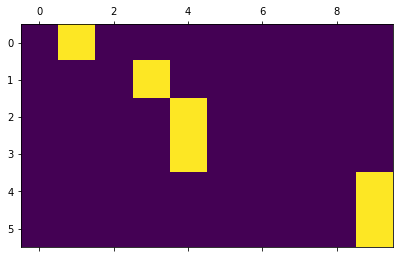

In [21]:
output_words, attentions = evaluate(
    encoder1, attn_decoder1, "je suis trop froid .")
plt.matshow(attentions.numpy())

For a better viewing experience we will do the extra work of adding axes and labels:

input = elle a cinq ans de moins que moi .
output = she s five years younger than me . <EOS>


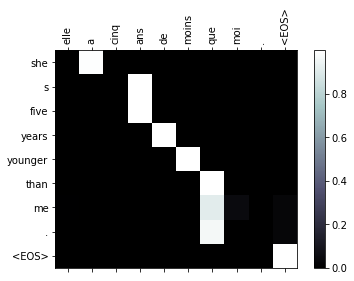

input = elle est trop petit .
output = she s too generous . <EOS>


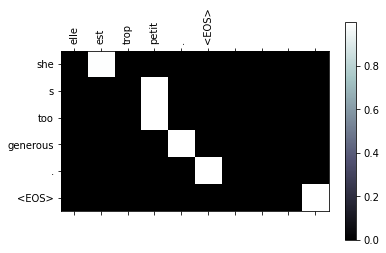

input = je ne crains pas de mourir .
output = i m not going to die . <EOS>


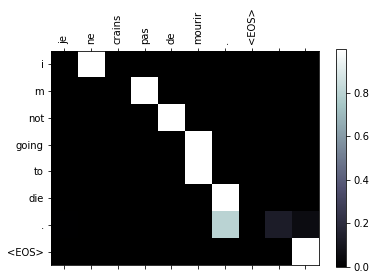

input = c est un jeune directeur plein de talent .
output = he is a talented young director . <EOS>


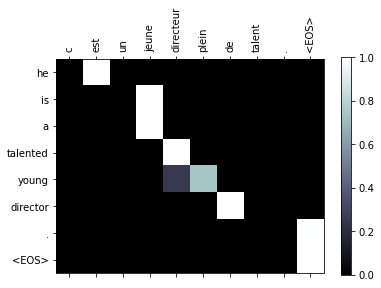

In [22]:
def showAttention(input_sentence, output_words, attentions):
    # Set up figure with colorbar
    fig = plt.figure()
    ax = fig.add_subplot(111)
    cax = ax.matshow(attentions.numpy(), cmap='bone')
    fig.colorbar(cax)

    # Set up axes
    ax.set_xticklabels([''] + input_sentence.split(' ') +
                       ['<EOS>'], rotation=90)
    ax.set_yticklabels([''] + output_words)

    # Show label at every tick
    ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

    plt.show()


def evaluateAndShowAttention(input_sentence):
    output_words, attentions = evaluate(
        encoder1, attn_decoder1, input_sentence)
    print('input =', input_sentence)
    print('output =', ' '.join(output_words))
    showAttention(input_sentence, output_words, attentions)


evaluateAndShowAttention("elle a cinq ans de moins que moi .")

evaluateAndShowAttention("elle est trop petit .")

evaluateAndShowAttention("je ne crains pas de mourir .")

evaluateAndShowAttention("c est un jeune directeur plein de talent .")

## Exercises
* Try with a different dataset
    * Another language pair
    * Human → Machine (e.g. IOT commands)
    * Chat → Response
    * Question → Answer
* Replace the embeddings with pre-trained word embeddings such as word2vec or GloVe
* Try with more layers, more hidden units, and more sentences. Compare the training time and results.
* If you use a translation file where pairs have two of the same phrase (I am test \t I am test), you can use this as an autoencoder. Try this:
    * Train as an autoencoder
    * Save only the Encoder network
    * Train a new Decoder for translation from there